In [1]:
import pickle
import pandas as pd
# from CITEsort.BTreeTraversal import BTreeTraversal
# from CITEsort.Visualize import plot_keymarker,visualize_tree
from Classifier.BTreeTraversal import BTreeTraversal
from Classifier.Visualize import plot_keymarker,visualize_tree
import matplotlib
#import numpy as np
from matplotlib import pyplot as plt

## load data and tree 

In [78]:
tree.right.right.left.indices

[5, 7, 13, 18, 20, 21]

In [2]:
# data = pd.read_csv('datasets/SeuratV4/adt_main_clr.csv',header=0,index_col=0)

# data = pd.read_csv('./datasets/SeuratV4/adt_p8_main_clr.csv',header=0,index_col=0)
id ='1'
data = pd.read_csv('../data/covid19/subdata/ADT_'+id+'.csv',index_col=0)
# data = pd.read_csv('../simulator_out/ADT_simulator_'+id+'.csv',index_col=0)
# data = pd.read_csv('../SeuratV4/subdata/'+id+'_ADT.csv', sep=',',index_col=0, header=0)
# data.index = data.index.astype(str)
id='9_1/_1'
f = open('../output/'+id+'/tree.pickle','rb')
# f = open('../data/4tumor/output/ADT_'+id+'/tree.pickle','rb')
# true = pd.read_csv('./data/4tumor/gating_cluster.csv',index_col=0)
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)

## plot compact tree or complete tree
#### The paramter '--compact' of runing runCITEsort.py will set the tree in compact format. If complete format is needed, plot tree again as below. The filename should no longer be 'tree', or the original tree.pdf will be overwritten.

In [ ]:
# visualize_tree(tree,data,outpath='./CITEsort_out',filename='tree_complete',compact=False)

In [3]:
import numpy as np
def smooth(x,item=0,num=6):
    if x.min().min() < 0:
    # i = [i for i in item][0]
    # print(i,value[:5])
    # print(value[0],value[1])
        x = x.apply(np.exp)

    # print('before',(x.isnull()).any())
    for i in x.columns:
        value = np.unique(x.loc[:,i].values.tolist())
        num = min(len(value),num)
        x.loc[:,i] += np.random.normal(loc=0, scale=1,size=x.shape[0]) * 0.01
        # for k in range(num-1):
        #     # print(x.loc[x.loc[:,i]==value[k],i])
        #     x.loc[x.loc[:,i]==value[k],i] += np.random.normal(loc=0, scale=1, size=sum(x.loc[:,i]==value[k])) * (value[k+1]-value[k])*0.1
        # print(i,':',len(value))

    y = np.apply_along_axis(lambda x: np.log(x+1) - np.mean(np.log(x+1)),0,x)
    x = pd.DataFrame(y, index=x.index, columns=x.columns)
    x.mask(x.isnull(),0)
    # print('after',(x.isnull()).any())
    return x


In [4]:
data_ = smooth(data)

## visualize all markers in a certain node
#### the node ID is just the number before the node name in tree.pdf

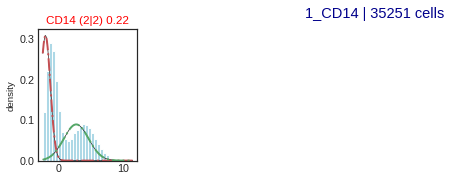

In [6]:
node_ID = 1
traversal.plot_node(data_,node_ID,viz_dim=1)

In [222]:
node = traversal.get_node(18)
# node.all_clustering_dic[1][('CD56-2',)] #[('CC_1','CC_3',)]#[('CD4-2',)]['mp_clustering']['similarity_stopped']
# len(node.indices)
node.score_dict
# node.stop
# node.artificial_w
# node.val_cnt['CD161']
# node.proba
# sum(node.proba[rnadata.obs['label_l1']=='CD4 T'] < 0.99)

{('CC_4', 'CC_5'): -24.531528674202743, ('CC_1', 'CC_5'): -109.30122028285211}

In [426]:
len(node.proba[rnadata.obs['label_l1']=='CD4 T'])

472

In [6]:
data_pair = pd.DataFrame({'CC_5':node.embedding.loc[:,'CC_5'],'CC_3':node.embedding.loc[:,'CC_3'],
                              'bp':node.all_clustering_dic[2][('CC_5','CC_3',)]['bp_clustering'],
                              'mp':node.all_clustering_dic[2][('CC_5','CC_3',)]['bp_clustering']},index=node.embedding.index)
# node.all_clustering_dic[2][('CC_5','CC_3',)]['mp_clustering']-node.all_clustering_dic[2][('CC_5','CC_3',)]['bp_clustering']

In [170]:
rnadata.obs['label_l2'].value_counts()

CD14 Mono        2034
NK                970
CD8 TEM           759
CD8 Naive         643
CD4 Naive         605
B naive           481
CD4 TCM           439
Platelet          369
gdT               305
B memory          180
cDC2              172
CD4 TEM           142
CD16 Mono         141
CD8 TCM            93
MAIT               68
pDC                50
NK_CD56bright      48
Treg               40
Plasmablast        10
CD4 CTL            10
HSPC                4
Name: label_l2, dtype: int64

In [149]:
len(node.embedding.loc[rnadata.obs['label_l2']=='Platelet','CC_1'])

14

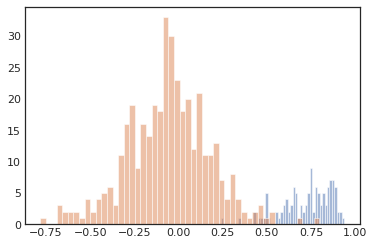

In [279]:
node = traversal.get_node(11)
# plt.hist(node.embedding['CC_1'],bins=100)
plt.hist(node.embedding.loc[rnadata.obs['label_l2']=='MAIT','CC_2'],bins=50, alpha=0.5)
plt.hist(node.embedding.loc[rnadata.obs['label_l2']=='CD8 TEM','CC_2'],bins=50, alpha=0.5)

# plt.hist(node.embedding.loc[rnadata.obs['label_l2']=='Treg','CC_1'],bins=50, alpha=0.5)
# plt.hist(node.embedding.loc[rnadata.obs['label_l2']=='CD4 CTL','CC_1'],bins=100)
# plt.hist(data_.loc[node.left_indices,'CD56-2'],bins=100)
# plt.hist(data_.loc[node.right_indices,'CD56-2'],bins=100)
# plt.hist(data_.loc[rnadata.obs['label_l1']=='NK','CD56-2'],bins=100)
# plt.hist(data_.loc[rnadata.obs['label_l2']=='NK_CD56bright','CD56-2'],bins=100)

# plt.scatter(node.embedding.loc[rnadata.obs['label_l2']=='CD16 Mono','CC_1'],node.embedding.loc[rnadata.obs['label_l2']=='CD16 Mono','CC_5'])
# plt.scatter(node.embedding.loc[rnadata.obs['label_l2']=='Platelet','CC_1'],node.embedding.loc[rnadata.obs['label_l2']=='Platelet','CC_5'])
# plt.scatter(node.embedding.loc[:,'CC_1'],node.embedding.loc[:,'CC_2'],alpha=0.5)
# plt.scatter(node.embedding.loc[rnadata.obs['label_l2']=='MAIT','CC_5'],node.embedding.loc[rnadata.obs['label_l2']=='MAIT','CC_3'])
# plt.scatter(data_.loc[node.indices,'CD56-2'],data_.loc[node.indices,'CD127'],alpha=0.5)
# plt.scatter(data_.loc[rnadata.obs['label_l2']=='NK','CD56-2'],data_.loc[rnadata.obs['label_l2']=='NK','CD127'],alpha=0.5)
# plt.scatter(data_.loc[rnadata.obs['label_l2']=='NK_CD56bright','CD56-2'],data_.loc[rnadata.obs['label_l2']=='NK_CD56bright','CD127'],alpha=0.5)
# plt.scatter(node.embedding.loc[rnadata.obs['label_l2']=='CD4 TEM','CC_5'],node.embedding.loc[rnadata.obs['label_l2']=='CD4 TEM','CC_3'])
# plt.scatter(data_.loc[node.left_indices,'CD56-2'],data_.loc[node.left_indices,'CD127'])
# plt.scatter(data_.loc[node.right_indices,'CD56-2'],data_.loc[node.right_indices,'CD127'])
# plt.scatter(data_.loc[node.indices,'CD25'][rnadata.obs['label_l2']=='Treg'],data_.loc[node.indices,'CD127'][rnadata.obs['label_l2']=='Treg'],alpha=0.5)
# plt.legend(['B naive','B memory'])
plt.show()



In [437]:
df = pd.DataFrame(index=node.indices,columns=node.embedding.columns)
df.loc[node.embedding.index,:] = node.embedding

In [277]:
import scanpy as sc
# rnadata = sc.read_h5ad('../SeuratV4/subdata/4_41_RNA.h5ad')
rnadata = sc.read_h5ad('../SeuratV4/subdata/4_5/t7p7_RNA.h5ad')


In [146]:
len(data_.loc[node.indices,'CD127'][rnadata.obs['label_l2']=='Treg'])

38

In [116]:
# tempnode = node


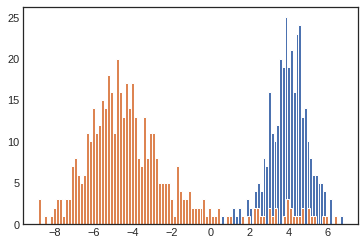

2.7750340075012225 -3.8970689871915143


In [135]:
# from sklearn.preprocessing import normalize
# node = tempnode
adata = rnadata[node.indices,:].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
w = pd.read_csv('../output/7_4_0/retrian_embedding.csv',index_col=0)
new_embedding = np.dot(adata.X.toarray(), w)
new_embedding = pd.Series(new_embedding[:,-2],index=adata.obs_names)
# plt.hist(new_embedding[node.indices],bins=100)
# plt.hist(new_embedding[node.left_indices],bins=100)
# plt.hist(new_embedding[node.right_indices],bins=100)
plt.hist(node.artificial_w,bins=100)
plt.hist(node.artificial_w[node.left_indices],bins=100)
plt.hist(node.artificial_w[node.right_indices],bins=100)

# sc.pp.highly_variable_genes(adata,min_disp=0.5)
# adata = adata[:,adata.var.highly_variable]
# # print(adata.shape)
# sc.pp.scale(adata)
# sc.pp.pca(adata, n_comps=100)
# ppdata = adata.obsm['X_pca'].T
# temp = normalize(ppdata[:5,:].T,copy=True)
# plt.scatter(ppdata[0,:],ppdata[1,:],s=1,c=pred0, cmap='viridis')
plt.show()
print(new_embedding[node.left_indices].mean(),new_embedding[node.right_indices].mean())

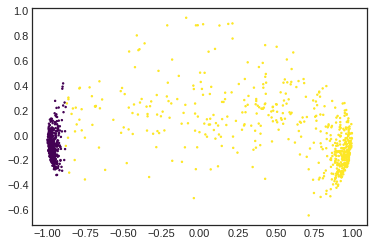

In [35]:
# temp = normalize(ppdata[:5,:].T,copy=True)
# plt.hist(temp[:,0],bins=100)
plt.scatter(temp[:,0],temp[:,1],s=2,c=pred1, cmap='viridis')
plt.show()
# temp[0,:]

In [24]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
pred0 = gmm.fit_predict(ppdata[0,:].reshape(-1,1))
pred1 = gmm.fit_predict(temp[:,0].reshape(-1,1))

In [261]:
id='7_5/new_0'
f = open('../output/'+id+'/tree_retrain.pickle','rb')
tree = pickle.load(f)

embedding = pd.DataFrame(index=rnadata.var_names)
def dfs_embedding(node,ind):
    ind  = ind + 1
    if node.key != ('leaf',):
        embedding[ind] = 0
        embedding.loc[node.artificial_w.index,ind] = node.artificial_w
        # ind += 1
        ind = dfs_embedding(node.left, ind)
        ind = dfs_embedding(node.right, ind)
    return ind
dfs_embedding(tree,ind=0)
embedding.to_csv('../output/7_5/new_0/embedding.csv')

In [259]:
embedding.iloc[:,14] = embedding1.iloc[:,14]

In [255]:
embedding1=embedding

In [15]:
import scanpy as sc
rnadata = sc.read_h5ad('../SeuratV4/subdata/4_31_RNA.h5ad')

In [116]:
import matplotlib.pyplot as plt
node = traversal.get_node(8)

# plt.hist(node.embedding,bins=100)
# plt.hist(x[:,0],bins=100,alpha=0.3)
subdata = rnadata[rnadata.obs['label_l2'].isin(['CD4 Naive','CD4 TCM'])]

plt.hist(node.embedding.iloc[rnadata[rnadata.obs['label_l2']=='CD4 TCM'].obs_names,0],bins=200)
plt.hist(node.embedding.iloc[rnadata[rnadata.obs['label_l2']=='CD4 Naive'].obs_names,0],bins=100)#node.embedding.iloc[:,0]
plt.show()

AttributeError: 'list' object has no attribute 'iloc'

In [72]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2)
# l = gm.fit_predict(np.array(node.embedding.iloc[:,0]).reshape(-1,1))
l = gm.fit_predict(x[:,0].reshape(-1,1))
sum(l)

506

In [71]:
from Classifier.adtReSplit import BIC, outlier_filter
from Classifier.adtReSplit import smooth as sm
from sklearn.preprocessing import normalize
raw = pd.DataFrame(node.embedding)
# x = sm(raw) #np.array(node.embedding.iloc[:,0]).reshape(-1,1)
x = normalize(node.embedding)
# x, _ = outlier_filter(node.embedding)
# k_bic,_ = BIC(np.array(node.embedding.iloc[:,0]).reshape(-1,1),10)
# k_bic,_ = BIC(np.array(x.iloc[:,0]).reshape(-1,1),10)
k_bic,_ = BIC(np.array(x[:,0]).reshape(-1,1),10)

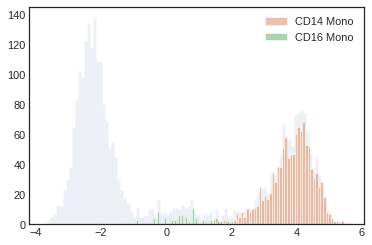

In [44]:
id='7_5/_rna_14'
f = open('../output/'+id+'/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)
rnadata = sc.read_h5ad('../SeuratV4/subdata/4_5/t3p6_RNA.h5ad')

nodeID = 3
node = traversal.get_node(nodeID)
sub1 = rnadata[rnadata.obs['label_l2']=='CD14 Mono',:]
sub2 = rnadata[rnadata.obs['label_l2']=='CD16 Mono',:]
x = node.artificial_w.loc[set(sub1.obs_names)&set(node.artificial_w.index)]
y = node.artificial_w.loc[set(sub2.obs_names)&set(node.artificial_w.index)]
# x = node.artificial_w.loc[set(node.left_indices)&set(node.artificial_w.index)]
# y = node.artificial_w.loc[set(node.right_indices)&set(node.artificial_w.index)]
z = node.artificial_w.loc[set(node.indices)&set(node.artificial_w.index)]
# w = node.artificial_w.loc[traversal.get_node(6).indices]


plt.hist(z,bins=100,alpha=0.1)

plt.hist(x,bins=100,alpha=0.5, label='CD14 Mono')
plt.hist(y,bins=100,alpha=0.5,label='CD16 Mono')
# plt.hist(w,bins=100,alpha=0.2, label='T')
plt.legend()
plt.show()

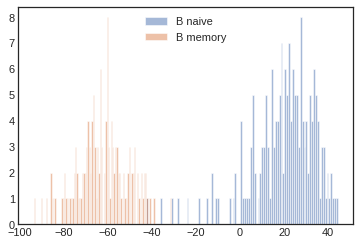

In [906]:
import scanpy as sc
id='7_5/_rna_0'
f = open('../output/'+id+'/tree_retrain.pickle','rb')
tree = pickle.load(f)
w0 = tree.left.right.artificial_w

id='7_5/_rna_4'
f = open('../output/'+id+'/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)
nodeID = 4
node = traversal.get_node(nodeID)

rnadata = sc.read_h5ad('../SeuratV4/subdata/4_5/t0p4_RNA.h5ad')
rnadata =rnadata[node.indices,:]
# rnadata = sc.read_h5ad('../data/4tumor/subdata/RNA_'+id+'.h5ad')
rnadata.var_names_make_unique()
sc.pp.normalize_total(rnadata, target_sum=1e4)
sc.pp.log1p(rnadata)
x = np.dot(rnadata[rnadata.obs['label_l2']=='B naive',w0.index].X.toarray(),w0.T)
y = np.dot(rnadata[rnadata.obs['label_l2']=='B memory',w0.index].X.toarray(),w0.T)
# x = np.dot(rnadata[node.left_indices,node.artificial_w.index].X.toarray(),node.artificial_w)
# y = np.dot(rnadata[node.right_indices,node.artificial_w.index].X.toarray(),node.artificial_w)
# x = np.dot(rnadata[node.left_indices,node.artificial_w.index].X.toarray(),w0.T)
# y = np.dot(rnadata[node.right_indices,node.artificial_w.index].X.toarray(),w0.T)
# z = np.dot(rnadata[traversal.get_node(6).indices,node.artificial_w.index].X.toarray(),node.artificial_w)


plt.hist(x,bins=100,alpha=0.5,label='B naive')
plt.hist(y,bins=100,alpha=0.5,label='B memory')
# plt.hist(z,bins=100,alpha=0.5,label='CD14 Mono')

plt.legend()
plt.show()

In [160]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
rnadata.obs['label'] = 0
rnadata.obs['label'].loc[node.right_indices] = 1
lda.fit(rnadata[node.indices,node.artificial_w.index].X.toarray(),rnadata.obs['label'].loc[node.indices])
w0 = lda.coef_

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(array([ 9.,  8.,  4.,  2.,  6.,  5.,  0.,  5., 10., 10.,  5.,  0.,  7.,
         6., 22., 13.,  7.,  7.,  7.,  0.,  9., 16., 15., 17., 24., 35.,
        21., 16., 24., 31., 24., 22., 40., 30., 27., 28., 38., 22., 16.,
        51., 30., 44., 26., 41., 23., 45., 27., 30., 37., 27., 43., 39.,
        15., 29., 24., 33., 27., 22., 33., 25., 20., 26., 18., 29., 14.,
        29., 12., 18., 26., 14.,  6.,  9., 20.,  8., 12.,  6., 12.,  4.,
         8., 11.,  7.,  4.,  3.,  6.,  3.,  3.,  7.,  3.,  4.,  1.,  0.,
         0.,  1.,  3.,  2.,  0.,  0.,  0.,  0.,  2.]),
 array([0.14550823, 0.16434208, 0.18317594, 0.2020098 , 0.22084366,
        0.23967752, 0.25851137, 0.27734523, 0.29617909, 0.31501295,
        0.3338468 , 0.35268066, 0.37151452, 0.39034838, 0.40918224,
        0.42801609, 0.44684995, 0.46568381, 0.48451767, 0.50335152,
        0.52218538, 0.54101924, 0.5598531 , 0.57868696, 0.59752081,
        0.61635467, 0.63518853, 0.65402239, 0.67285624, 0.6916901 ,
        0.71052396, 0.7293

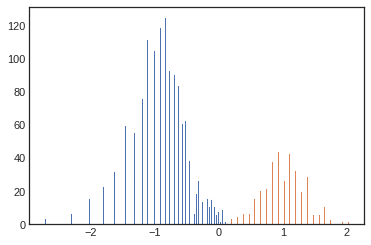

In [158]:
plt.hist(data_.loc[node.left_indices, 'CD3-1'],bins=100)
plt.hist(data_.loc[node.right_indices, 'CD3-1'],bins=100)


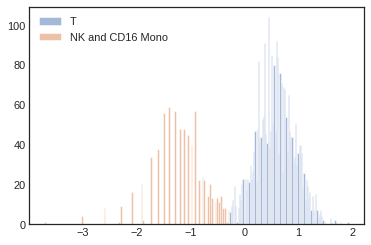

In [59]:
plt.hist(data_.loc[traversal.get_node(4).indices,'CD3-1'],bins=100,alpha=0.5,label='T')
plt.hist(data_.loc[traversal.get_node(3).indices,'CD3-1'],bins=100,alpha=0.5,label='NK and CD16 Mono')
plt.legend()
plt.show()

In [88]:
from scipy.stats import multivariate_normal, norm
def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None, confidence_threshold=0, throw=True):
    """confidence_threshold is used to not assign dots with low confidence to each group:
        a big confidence_threshold represents a more strict standard for confidential dots"""
    confidence_threshold = (1-confidence_threshold) / len(weight) * 2
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print('sample_null',sample.loc[:,marker_list].isnull().any().any(), 'mean_null', mean_list[i][marker_list].isnull().any().any(), 'cov_null', cov_list[i].loc[marker_list,marker_list].isnull().any().any())
            # print('marker len:',marker_list[i].shape[0])
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    if throw:
        pred_label = [pred_label[i] if p_post[i,pred_label[i]]<confidence_threshold else -1 for i in range(len(pred_label)) ]
        print('throw')
    # print(p_post[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)    
    return pred_label

In [103]:
leaf_list = [node for node in traversal.nodelist if node.stop!=None]
marker_list = [node.marker[i] for node in leaf_list for i in range(len(node.marker))]
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list] 
marker_list = list(set(marker_list))
y = np.apply_along_axis(lambda x: np.log(x+1) - np.mean(np.log(x+1)),0,data)
x = pd.DataFrame(y, index=data.index, columns=data.columns)
new_label = assign_GMM(x, mean_list, cov_list, w_list, marker_list=marker_list, if_log=True, confidence_threshold=0, throw=False)
for i in range(len(leaf_list)):
    node = leaf_list[i]
    sub_data = data[new_label==i]
    node.indices = sub_data.index.tolist()

/tmp/ipykernel_2798123/1560725178.py:10: RuntimeWarning: divide by zero encountered in log
  type_num = np.log(weight/sum(weight))
/tmp/ipykernel_2798123/1560725178.py:27: RuntimeWarning: invalid value encountered in true_divide
  p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )


In [104]:
label = pd.DataFrame({'GEM':data.index,'Label':[None]*len(data)},index=data.index)
for i in range(len(leaf_list)):
    if leaf_list[i].key == ('leaf',):
        label.loc[leaf_list[i].indices,'Label'] = str(leaf_list[i].ind)+'_'+'_'.join(leaf_list[i].key) 

In [105]:
label.to_csv('../output/3_2_/' + '/new_leaf_labels.csv')

In [101]:
ind = 0
def dfs(node,id):
    if node.key == ('leaf',):
        node.indices = leaf_list[i].indices
        if node.ind != leaf_list[i].ind:
            print(node.ind, leaf_list[i].ind)
        ind = ind +1
        return node       
    else:
        
        node.left = dfs(node.left,id)
        node.right = dfs(node.right,id)
        return node

new_tree = dfs(tree,0)

11 30


UnboundLocalError: local variable 'ind' referenced before assignment

In [ ]:
def cutleaf_dfs(node, cutID, cut=False):
    if node.ind in cutID:
        return 
    
    if node.key == ('leaf',):
        if cut == True:
            node.key = ('cutleaf',)
        return node       
    else:
        if cut:
            node.key = ('cutleaf',)
        if node.ind in cutID:
            node.key = ('leaf',)
            cut = True
        
        print(node.ind)
        node.left = cutleaf_dfs(node.left, cutID, cut=cut)
        node.right = cutleaf_dfs(node.right, cutID, cut=cut)
        if node.left == None:
            node = node.right
        if node.right == None:
            node = node.left
        return node

In [28]:
def finetune_dfs(node, cutID=[], removeID=[], cut=False):
    if node == None:
        return node
    # ind = node.ind
    node.ind = [i for i in range(len(traversal.nodename)) if len(traversal.nodelist[i].indices)==len(node.indices)][0]
    # if node.ind == 4 or node.ind == 9 or ind==4 or ind==9:
        # print(ind,node.ind)
    print(node.ind,node.key)
    # if node.ind == 7:
    #     node.indices = node.indices +  traversal.get_node(11).indices
    # if node.ind == 12:
    #     node.indices = node.indices +  traversal.get_node(25).indices
    # if node.ind == 36:
    #     node.indices = node.indices +  traversal.get_node(20).indices 

    if node.ind in removeID:
        node.key = ('remove',)
        return node
    if node.key == ('leaf',):
        if cut == True:
            node.key = ('cutleaf',)
        return node       
    else:
        if cut:
            node.key = ('cutleaf',)
        if node.ind in cutID:
            node.key = ('leaf',)
            cut = True
            print('newleaf',node.ind)
            node.left = None
            node.right = None
            return node
        
        
        node.left = finetune_dfs(node.left, cutID, removeID=removeID, cut=cut)
        node.right = finetune_dfs(node.right, cutID, removeID=removeID, cut=cut)
        
        if node.left.key == ('remove',) and node.right.key == ('remove',):
            node.key = ('remove',)
            return node
        if node.left.key == ('remove',):
            node = node.right
        if node.right.key == ('remove',):
            node = node.left
        return node

In [61]:
def finetune_dfs(node, cutID, removeID=[], cut=False):

    if node.ind in removeID:
        return 
    
    if node.key == ('leaf',):
        if cut == True:
            node.key = ('cutleaf',)
        return node       
    else:
        if cut:
            node.key = ('cutleaf',)
        if node.ind in cutID:
            node.key = ('leaf',)
            cut = True
        
        print(node.ind)
        node.left = finetune_dfs(node.left, cutID, cut=cut)
        node.right = finetune_dfs(node.right, cutID, cut=cut)

        if node.left == None:
            node = node.right
        if node.right == None:
            node = node.left
        return node

In [29]:
newtree = finetune_dfs(tree, cutID=[6],removeID=[3])#, cutID=[8, 9, 14,25,27,28,24]

0 ('CD185',)
1 ('CD196',)
3 ('leaf',)
4 ('CCR10',)
5 ('CD196',)
7 ('CD194',)
11 ('leaf',)
12 ('leaf',)
8 ('CD194',)
13 ('leaf',)
14 ('leaf',)
6 ('CD185',)
newleaf 6
2 ('leaf',)


In [30]:
visualize_tree(newtree,data_,'../output/'+id,'/cuttree',compact=True)
# visualize_tree(newtree,data_,'../data/4tumor/adt_output','/cuttree',compact=True)
    
f = open('../output/'+id+'/cuttree.pickle','wb')
# f = open('../data/4tumor/adt_output/cuttree.pickle','wb')
pickle.dump(newtree,f)
f.close()

newtravel = BTreeTraversal(newtree)
newleaf = newtravel.get_leaf_label()
leaves_labels = newtravel.get_leaf_label()
# leaves_labels.to_csv('../data/4tumor/adt_output/cut_leaf_labels.csv')
leaves_labels.to_csv('../output/' +id+ '/cut_leaf_labels.csv')

/home/xinzhu/Desktop/git-test/CITE-sortV2


In [21]:
newtravel.nodename

['0_CD14',
 '1_CD4',
 '2_leaf',
 '3_CD8a',
 '4_CD45RA',
 '5_CD45RA',
 '6_PD-1',
 '7_leaf',
 '8_CD3',
 '9_leaf',
 '10_CD19',
 '11_CD127',
 '12_leaf',
 '13_CD45RO_TIGIT',
 '14_TIGIT',
 '15_CD3',
 '16_leaf',
 '17_leaf',
 '18_leaf',
 '19_leaf',
 '20_leaf',
 '21_CD127_PD-1',
 '22_leaf',
 '23_leaf',
 '24_leaf',
 '25_leaf',
 '26_leaf']

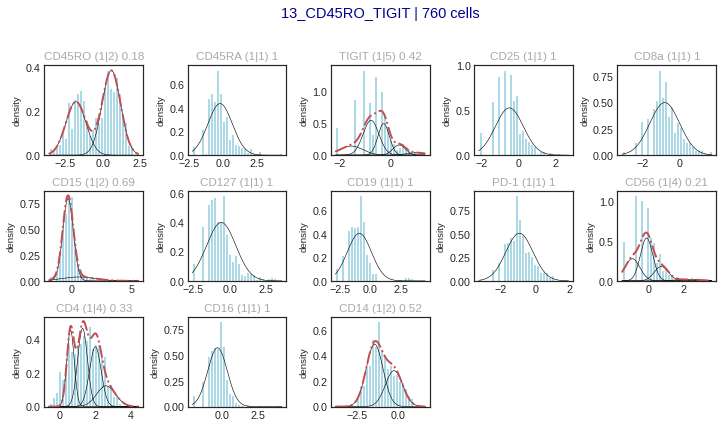

In [34]:
node_ID = 13

newtravel.plot_node(data_,node_ID,viz_dim=1)

In [51]:
newtravel.get_node(19).key

('leaf',)

In [ ]:
import diptest
diptest.dipstat(data.loc[node.indices,'CD8a'])
# len(data.loc[node.indices,'CD158'])

In [ ]:
traversal.plot_node_umap(data, nodeID=6)

In [ ]:
traversal.plot_node_2dim_new(data, 7, 'CD27', 'CD16')
# traversal.plot_node_2dim_new(data, 20, 'CD8a', 'CD4')
# traversal.plot_node_2dim_new(data, 2, 'CD4-1', 'CD19')

In [ ]:
score_ll = traversal.get_ll(4)
print('likelyhood gain:')
for key,value in score_ll.items():
    print(key,round(value,3))

## visualize the key marker in a certain node
#### the node ID is just the number before the node name in tree.pdf

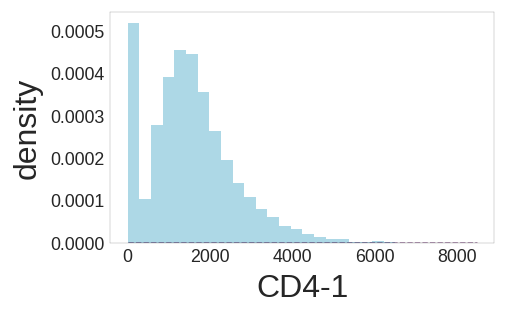

In [35]:
plot_keymarker(data,traversal,node_ID=1,dpi=128)

In [ ]:
from scipy.stats import multivariate_normal, norm
import numpy as np

def assign_GMM(sample, mean_list, cov_list, weight, if_log=False, marker_list=None):
    # print(cov_list)
    index = sample.index
    # sample = np.array(sample)
    weight = np.array(weight)
    if if_log:
        type_num = np.log(weight/sum(weight))
    else:
        type_num = weight/sum(weight)
    
    p_prior = np.zeros(shape=(len(sample),len(weight)))
    for i in range(len(weight)):
        if if_log:
            # print(i)
            p_prior[:,i] = multivariate_normal.logpdf(np.array(sample.loc[:,marker_list]), mean=np.array(mean_list[i][marker_list]), cov=np.array(cov_list[i].loc[marker_list,marker_list]),allow_singular=True)
            p_prior[:,i] = p_prior[:,i] + type_num[i]
            
        else:
            
            # print([cov_list[i][j,j] for j in range(len(cov_list[i]))])
            # print(sample.loc[:,marker_list[i]])
            # print(mean_list[i])
            # print(cov_list[i])
            p_prior[:,i] = multivariate_normal.pdf(np.array(sample.loc[:,marker_list[i]]), mean=np.array(mean_list[i]), cov=np.array(cov_list[i]))   
            p_prior[:,i] = p_prior[:,i] * type_num[i]
    # p_prior = -p_prior 
    
    p_post = p_prior / (p_prior.sum(axis=1)[:,np.newaxis] )
    pred_label = np.argmin(p_post,axis=1)
    # print(p_prior[:10,:])
    # print(pred_label[:10])
    pred_label = pd.Series(data=pred_label,index=index)
    return pred_label

In [ ]:
leaf_list = traversal.nodelist.copy()
leaf_list.pop(0)
leaf_list.pop(0)
leaf_list.pop(1)

In [ ]:
node = traversal.get_node(3)
mean_list = [node.mean for node in leaf_list] 
cov_list = [node.cov for node in leaf_list]
w_list = [node.weight for node in leaf_list]
simulator = pd.read_csv('../simulator/ADT_simulator_9_10.csv', sep=',', index_col=0, header=0)
raw_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8'])
add_label = assign_GMM(simulator, mean_list, cov_list, w_list, if_log=True,marker_list=['CD4-1','CD19','CD16','CD8','CD3-1'])
#### 尝试用所有cutof<0.5的feature来assign，相当于是一个高维的gate

In [ ]:
import umap
import umap.plot
import matplotlib.pyplot as plt

mapper = umap.UMAP().fit(simulator)
umap.plot.points(mapper, labels=raw_label)
umap.plot.points(mapper, labels=add_label)

In [ ]:
raw_label.iloc[20675:].value_counts()
# add_label.iloc[20675:].value_counts()

In [ ]:
# add_label.index = simulator.index
simulator[raw_label==3].to_csv('../simulator/ADT_simulator_9_11.csv')

In [ ]:
from CITEsort.Visualize import visualize_2dim

visualize_2dim(simulator[raw_label==3]['CD3-1'],simulator[raw_label==3]['CD8'],raw_label[raw_label==3])
visualize_2dim(simulator[add_label==3]['CD3-1'],simulator[add_label==3]['CD8'],add_label[add_label==3])

In [ ]:
keys = []
for i in range(28):
    node = traversal.get_node(i)
    if list(node.key) != 'leaf':
        print(node.key)

In [ ]:
'IgD',
'CD26-1',
'CD72',
'CD4-1',
'CD27', 'CD8a
'CD8a',
'CD244',
'CD4-1',
'CD27',
'CD244',
'CD158', 'CD21',
'CD3-1'